# Advanced Lane Finder

### Calibrate Camera

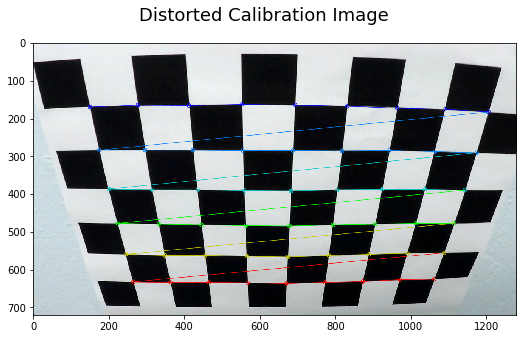

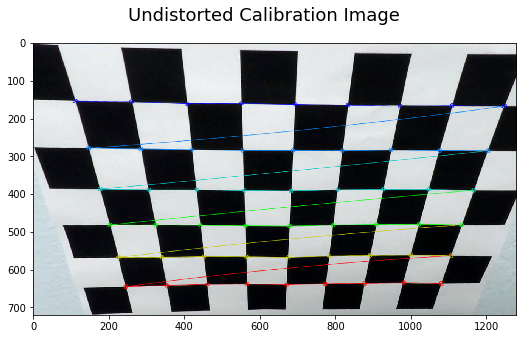

Camera Matrix
[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob


# prepare object points
nx = 9
ny = 6

objpoints = []
imgpoints = []

objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

calibration_images = glob.glob('./camera_cal/calibration*.jpg')

for idx, image_path in enumerate(calibration_images):
    # Make a list of calibration images
    img = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if image_path == './camera_cal/calibration2.jpg':
        sample_image = np.copy(img)
        cv2.drawChessboardCorners(sample_image, (nx, ny), corners, ret)
    
    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


fig = plt.figure(figsize=(12, 5))
fig.suptitle('Distorted Calibration Image', fontsize=18)
plt.imshow(sample_image)
plt.show()

fig = plt.figure(figsize=(12, 5))
fig.suptitle('Undistorted Calibration Image', fontsize=18)
undist = cv2.undistort(sample_image, mtx, dist, None, mtx)
plt.imshow(undist)
plt.show()

print('Camera Matrix')
print(mtx)

### Processing Pipeline

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [3]:
PLOT_SAMPLES = False

def sliding_window_search(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#     if PLOT_SAMPLES:
#         fig = plt.figure(figsize=(12, 5))
#         fig.suptitle('Sliding Window Line Fitting', fontsize=18)
#         plt.imshow(out_img)
#         plt.plot(left_fitx, ploty, color='yellow')
#         plt.plot(right_fitx, ploty, color='yellow')
#         plt.xlim(0, 1280)
#         plt.ylim(720, 0)
#         plt.show()
    
    return left_fit, right_fit


def search_from_previous_fit(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
#     if PLOT_SAMPLES:
#         fig = plt.figure(figsize=(12, 5))
#         fig.suptitle('Targeted Search Region', fontsize=18)
#         plt.imshow(result)
#         plt.plot(left_fitx, ploty, color='yellow')
#         plt.plot(right_fitx, ploty, color='yellow')
#         plt.xlim(0, 1280)
#         plt.ylim(720, 0)
#         plt.show()

    return left_fit, right_fit, left_fitx, right_fitx


def draw_lane(warped_binary, original_img, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(0,0,255), thickness=25)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=25)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.4, 0)
    
#     if PLOT_SAMPLES:
#         fig = plt.figure(figsize=(12, 5))
#         fig.suptitle('Lane Detection', fontsize=18)
#         plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
#         plt.show()
    
    return result


def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)


def persp_transform(img, original_image):
    offset = 400
    
    w = img.shape[1]
    h = img.shape[0]
    
    img_size = (w, h)
    
    src = np.float32([
        (575, 464),
        (710, 464), 
        (220, 710), 
        (1088, 710)
    ])
    
    dst = np.float32([
        (offset, 0),
        (w - offset, 0),
        (offset, h),
        (w - offset, h)
    ])
    
    if PLOT_SAMPLES:
        fig = plt.figure(figsize=(12, 5))
        fig.suptitle('Perspective Transform Boundary', fontsize=18)
        preview = cv2.cvtColor(np.copy(original_image), cv2.COLOR_BGR2RGB)
        cv2.line(preview, tuple(src[0]), tuple(src[1]), (255,0,0), 5)
        cv2.line(preview, tuple(src[1]), tuple(src[3]), (255,0,0), 5)
        cv2.line(preview, tuple(src[3]), tuple(src[2]), (255,0,0), 5)
        cv2.line(preview, tuple(src[2]), tuple(src[0]), (255,0,0), 5)
        plt.imshow(preview)
        plt.show()

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    channel = hls[:,:,2]
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):    
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output


def lthresh(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    binary = np.zeros_like(l_channel)
    binary[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    
    return binary


def sthresh(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary = np.zeros_like(s_channel)
    binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary


def bthresh(img, thresh):
    b_channel = img[:,:,2]
    binary = np.zeros_like(b_channel)
    binary[(b_channel >= thresh[0]) & (b_channel <= thresh[1])] = 1
    
    return binary


def pipeline(img):
    ksize=5
    
    img = undistort(img)
    
    # Apply each of the thresholding functions
    gradx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(100, 255))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.2))
    
    # Extract L and B channels
    l_binary = lthresh(img, thresh=(220, 255))
    b_binary = bthresh(img, thresh=(220, 255))
    
    combined_binary = np.zeros_like(gradx_binary)
    combined_binary[((gradx_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | 
                    (l_binary == 1) | (b_binary == 1)] = 1

#     if PLOT_SAMPLES:
#         fig = plt.figure(figsize=(12, 5))
#         fig.suptitle('Lightness Channel Threshold', fontsize=18)
#         plt.imshow(l_binary, cmap='gray')
#         plt.show()

#         fig = plt.figure(figsize=(12, 5))
#         fig.suptitle('Blue Channel Threshold', fontsize=18)
#         plt.imshow(b_binary, cmap='gray')
#         plt.show()

#         fig = plt.figure(figsize=(12, 5))
#         fig.suptitle('Final Binary Image', fontsize=18)
#         plt.imshow(combined_binary, cmap='gray')
#         plt.show()
    
    persp, M, Minv = persp_transform(combined_binary, img)
    
    if PLOT_SAMPLES:
        fig = plt.figure(figsize=(12, 5))
        fig.suptitle('Perspective Transform', fontsize=18)
        plt.imshow(persp, cmap='gray')
        plt.show()

#         histogram = np.sum(persp[persp.shape[0]//2:,:], axis=0)
#         fig = plt.figure(figsize=(8.75, 5))
#         fig.suptitle('Histogram of Persp.', fontsize=18)
#         plt.plot(histogram)
#         plt.show()
    
    sw_left_fit, sw_right_fit = sliding_window_search(persp)
    
    left_fit, right_fit, left_fitx, right_fitx = search_from_previous_fit(persp, sw_left_fit, sw_right_fit)
    
    output = draw_lane(persp, img, left_fitx, right_fitx, Minv)
    
    return output



### Test Images

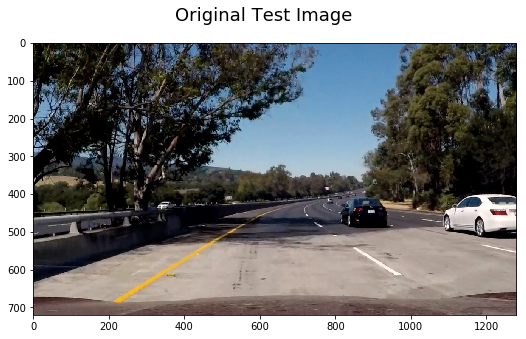

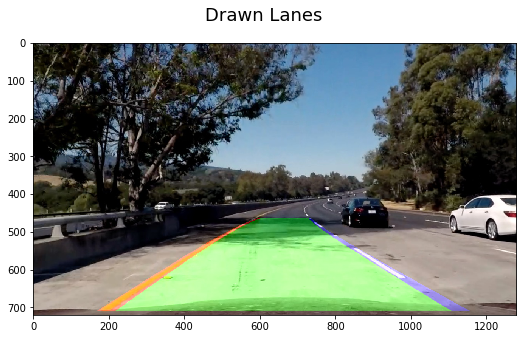

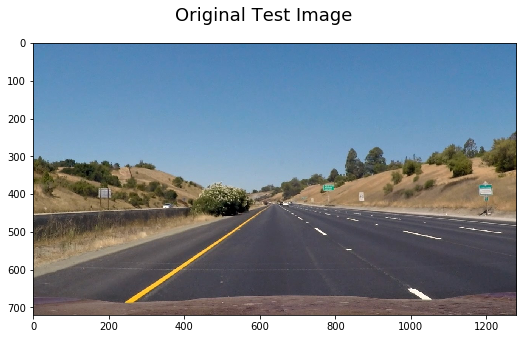

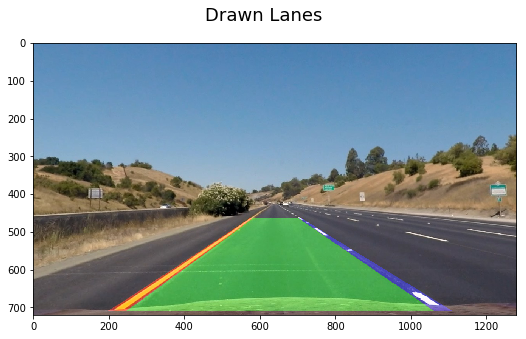

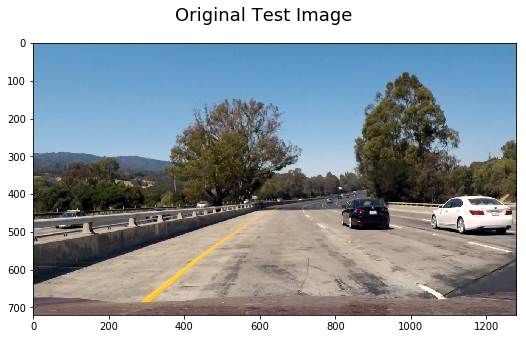

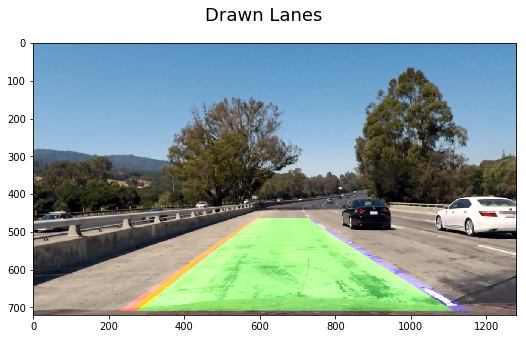

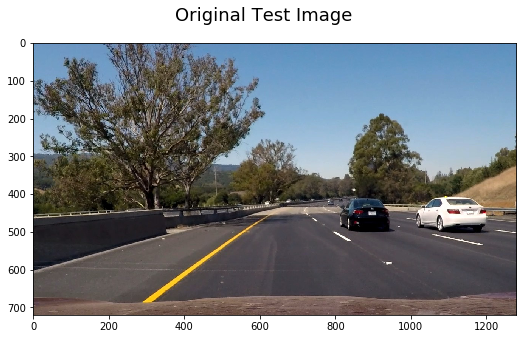

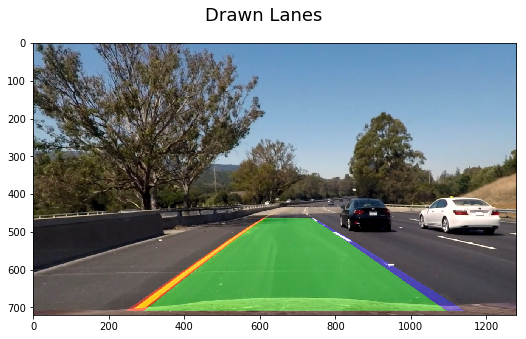

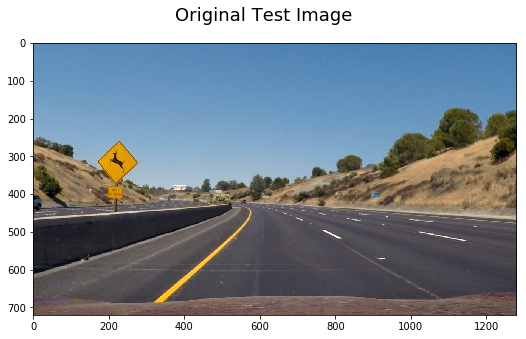

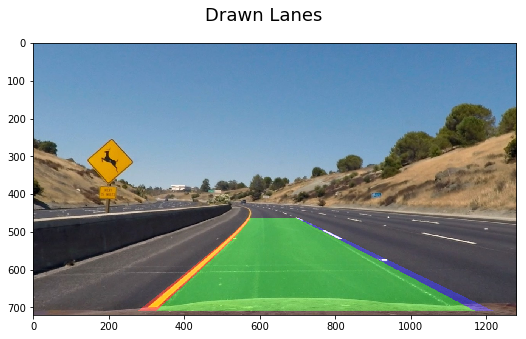

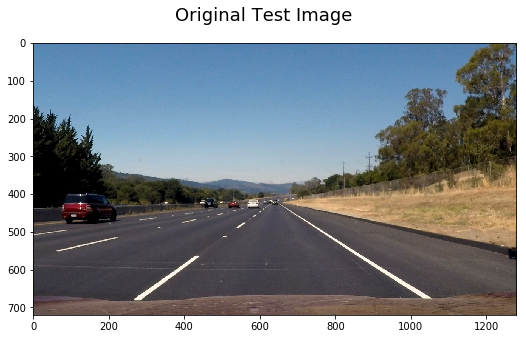

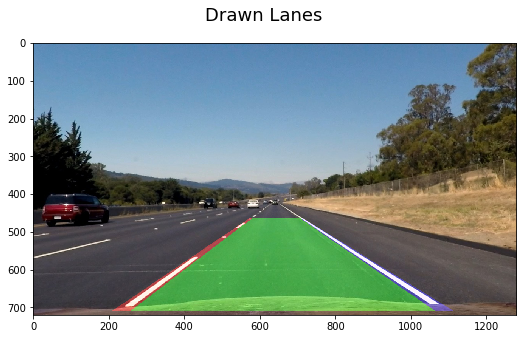

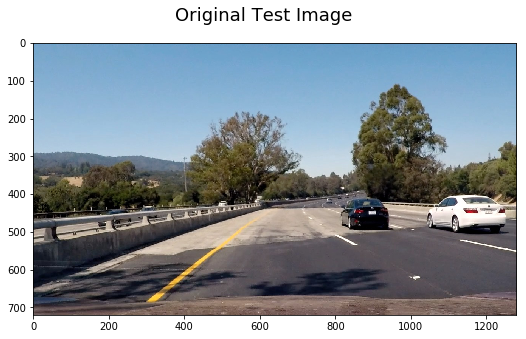

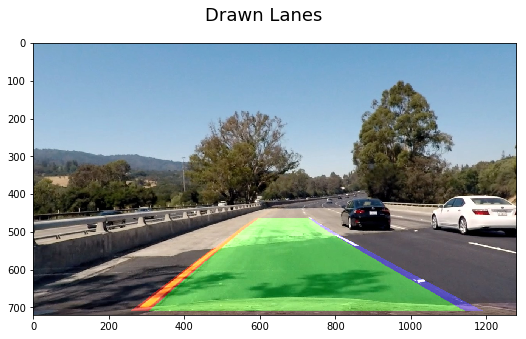

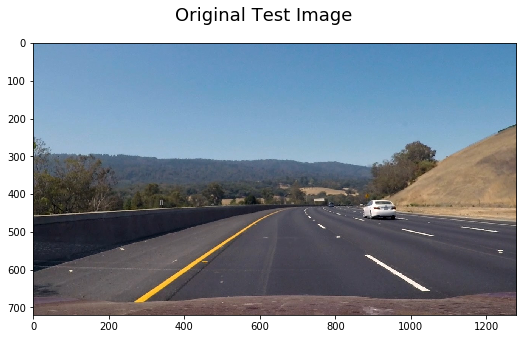

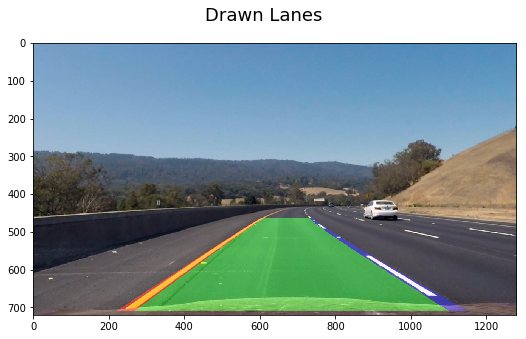

In [4]:
# test_images = glob.glob('./test_images/test2.jpg')
test_images = glob.glob('./test_images/*.jpg')


for image_path in test_images:
    img = cv2.imread(image_path)
    
#     if PLOT_SAMPLES:
    fig = plt.figure(figsize=(12, 5))
    fig.suptitle('Original Test Image', fontsize=18)
    color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(color)
    plt.show()
    
    output = pipeline(img)
    
    fig = plt.figure(figsize=(12, 5))
    fig.suptitle('Drawn Lanes', fontsize=18)
    color = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    plt.imshow(color)
    plt.show()
    


### Run on Sample Video

In [5]:
from moviepy.editor import VideoFileClip

project_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("./project_video.mp4").subclip(0,10)
# clip1 = VideoFileClip("./project_video.mp4")
output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(project_output, audio=False) 

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 250/251 [01:05<00:00,  3.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 2min, sys: 5.78 s, total: 2min 6s
Wall time: 1min 6s


In [8]:
from IPython.display import HTML


HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))